# Estimating Optimal Solutions for Combinatorial Optimization Problems

Let $S$ be a sample of size $m$ from a probability distribution bounded below by $a$, let $z$ be the minimum value in the sample. As $m$ increases, the distribution of $z$ approaches a *Weibull distribution* having $a$ as its location parameter (displacement) (Goden and Alt, 1979; Rardin and Uzsoy, 2001).

The CDF of the Weibull distribution is $F_x(x_0) = prob\{x \leq x_0\} = 1 - e^{-(\frac{x_0-a}{b})^c}$, where $a$ is the location parameter, $b$ is the scale parameter, and $c$ the shape parameter.

By considering $k$ samples and their corresponding minimum values $z_1, \ldots, z_k$, we can try to estimate the parameters of the Weibull distribution. We will assume $z_1, \ldots, z_k$ are in non-decreasing order.

We can use this result to estimate the value of the optimal solution of a combinatorial optimization problem.

By taking a problem instance as a probability distribution, the best solution in a sample $m$ random solutions for the instance should approach a Weibull distribution. By considering $k$ samples, we can estimate the distribution parameters, in particular, $a$ is an estimate of the optimal solution value.

## An example - The Traveling Salesman Problem
Sample $n$ points on a 2D plane:

In [82]:
import random

n = 10
side = 100
x = [random.random()*side for i in range(n)]
y = [random.random()*side for i in range(n)]

Plot the points:

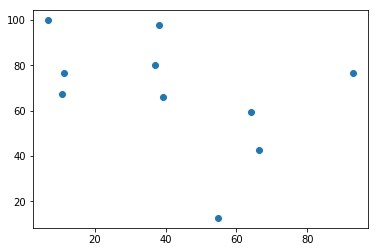

In [83]:
import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.show()

Functions for the distance between two vertices and cost of a solution:

In [84]:
import math

def distance(u, v):
    return ((x[u]-x[v])**2+(y[u]-y[v])**2)**(1/2)

def cost(s):
    return sum(distance(s[u], s[(u+1)%n]) for u in range(n))

Function for generating a random solution:

In [85]:
def randSol():
    s = list(range(n))
    random.shuffle(s)
    
    return s

Function for obtaining the best solution from a sample of $m$ random solutions:

In [86]:
def minimum(m):
    return min(cost(randSol()) for i in range(m))

Function for obtaining the best solutions of $k$ samples of $m$ solutions each:

In [87]:
def minima(k, m):
    return sorted([minimum(m) for i in range(k)])

Lets plot a histogram of $z_1, \ldots, z_k$

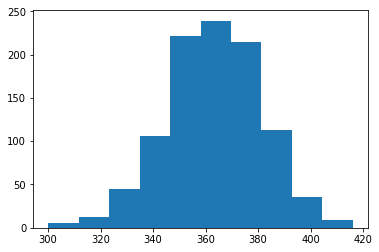

300.1400186307031

In [88]:
k = 1000
m = 100
z = minima(k, m)
plt.hist(z)
plt.show()
z[0]

## Estimating the Weibull Distribution Parameters

A point estimate for the optimal value $a$ given by Golden and Alt (1979) is $\tilde{a} = 2z_1 - z_2$. An estimate given by Zanakis (1979) is $\hat{a} = \frac{z_1z_n-z_2^2}{z_1+z_n-2z_2}$. Cooke (1979) proposes $a^* = 2z_1-(e-1)\sum_{i=1}^{k}\frac{z_i}{e^i}$.

Acording to Zanakis and Evans (1981) the order of accuracy is $a^*$, $\hat{a}$, $\tilde{a}$.

A $1-e^{-k}$% confidence interval for $a$ was proposed by Golden and Alt (1979): $[z_1-\tilde{b}, z_1]$, where $\tilde{b} = z_{\lfloor 0.63k \rfloor+1} - \overline{a}$; $\overline{a}$ can be $\tilde{a}, \hat{a}, a^*$.

Golden and Alt (1979) also give an estimate for $c$, $\tilde{c} = \frac{\ln(-\ln(0.5))}{\ln(z_M-\overline{a})-\ln{\overline{b}}}$, where $z_M$ is the median of $z_1, \ldots, z_k$.

In fact, Golden and Alt (1979) recommend using Maximum Likelihood Estimation (MLE) to refine $\overline{a}$, $\tilde{b}$, $\tilde{c}$. According to Zanakis and Evans (1981), this is not justifiable.

In [89]:
from scipy.stats import weibull_min
from math import log as ln
from statistics import median
import pandas as pd

def estimates(a):
    b = z[math.floor(0.63*k)+1]-a
    c = ln(-ln(0.5))/(ln(median(z)-a)-ln(b))
    linf = z[0]-b
    lsup = z[0]
    return {'a':a, 'b':b, 'c':c, 'linf':linf, 'lsup':lsup}

# Golden and Alt, 1979
golden = estimates(2*z[0]-z[1])

# Zanakis (1979)
zanakis = estimates((z[0]*z[-1]-z[1]**2)/(z[0]+z[-1]-2*z[1]))

# Cooke 1979.
cooke = estimates(2*z[0]-(math.e-1)*(sum(math.exp(-(i+1))*z[i] for i in range(k))))

# Scipy Maximum Likelihood Estimate (MLE)
cMLE, aMLE, bMLE = weibull_min.fit(z, cooke['c'], loc = cooke['a'], scale = cooke['b']) # shape, location, scale
MLE = {'a':aMLE, 'b':bMLE, 'c':cMLE, 'linf':z[0]-bMLE, 'lsup':z[0]}

df = pd.DataFrame([golden, zanakis, cooke, MLE], 
                  index = ['Goden and Alt (1979)', 'Zanakis (1979)', 'Cooke (1979)', 'MLE'])
df

,a,b,c,linf,lsup
Goden and Alt (1979),300.140019,69.693116,3.661568,230.446902,300.140019
Zanakis (1979),300.140019,69.693116,3.661568,230.446902,300.140019
Cooke (1979),299.451226,70.381910,3.699629,229.758109,300.140019
MLE,283.868926,86.388406,4.898570,213.751613,300.140019


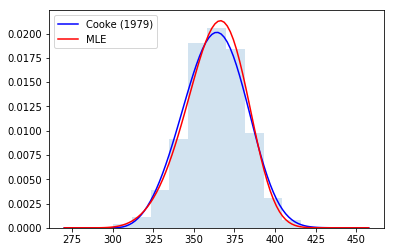

In [90]:
import numpy as np

ls = np.linspace(0.9*z[0], 1.1*z[-1], 100)

plt.plot(ls, weibull_min(c = cooke['c'], loc = cooke['a'], scale = cooke['b']).pdf(ls), '-b', label = 'Cooke (1979)')
plt.plot(ls, weibull_min(c = MLE['c'], loc = MLE['a'], scale = MLE['b']).pdf(ls), '-r', label = 'MLE')
plt.hist(z, density=True, alpha=0.2)
plt.legend(loc="upper left")
plt.show()

Lets obtain the optimal solution by enumeration (only for very small $n$):

In [91]:
def enumeration(n):
    i = 0
    s = [-1]*n
    visited = [False]*n
    
    while i >= 0:
        if not s[i] == -1:
            visited[s[i]] = False
        s[i] += 1
        while s[i] < n and visited[s[i]]:
            s[i] += 1
        
        if s[i] == n:
            s[i] = -1
            i -= 1
        else:
            visited[s[i]] = True
            
            if i < n-1:
                i += 1
            else:
                yield cost(s)
                
opt = min(enumeration(n))
opt

300.1400186307031

## References

P. Cooke. Statistical Inference for Bounds of Random Variables. Biometrika. 1979.

B. L. Golden and F. B. Alt. Interval Estimation of a Global Optimum for Large Combinatorial Problems. Naval Research Logistics Quarterly. 1979.

R. L. Rardin and R. Uzsoy. Experimental Evaluation of Heuristic Optimization Algorithms: A Tutorial. Journal of Heuristics. 2001.

S. H. Zanakis. A Simulation Study of Some Simple Estimators for the Three-parameter Weibull Distribution. Journal of Statistical Computation and Simulation. 1979.

S. H. Zanakis and J. R. Evans. Heuristic "Optimization": Why, When, and How to Use It. Interfaces. 1981.